In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

### Loading and Analyzing the Data

In [ ]:
data = pd.read_csv('heart_failure.csv')

data.head()
print(data.columns)
print(data.shape)
print(data.info())

Index(['Unnamed: 0', 'age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT', 'death_event'],
      dtype='object')
(299, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                299 non-null    int64  
 1   age                       299 non-null    float64
 2   anaemia                   299 non-null    object 
 3   creatinine_phosphokinase  299 non-null    int64  
 4   diabetes                  299 non-null    object 
 5   ejection_fraction         299 non-null    int64  
 6   high_blood_pressure       299 non-null    object 
 7   platelets                 299 non-null    float64
 8   serum_creatinine          299 non-null    float64
 9   ser

In [ ]:
print('Classes and number of values in the dataset:', Counter(data['death_event']))
 
y = data.death_event
x = data.iloc[:, 1: -2]
print(x.columns)

Classes and number of values in the dataset: Counter({'no': 203, 'yes': 96})
Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')


### Data Preprocessing

In [ ]:
x = pd.get_dummies(x)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

ct = ColumnTransformer([('numeric', StandardScaler(), ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time'])])

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)


### Prepare Labels For Classification

In [ ]:
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.transform(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

### Design the Model


In [ ]:
model = Sequential()
model.add(InputLayer(input_shape = (X_train.shape[1],)))
model.add(Dense(12, activation = 'relu'))
model.add(Dense(6, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation = 'softmax'))


model.compile(loss= 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

### Train and Evaluate the Model 

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta = 0.0001, verbose=1, patience=20)
history = model.fit(X_train, Y_train, epochs = 50, batch_size = 8, verbose = 1, callbacks = [es], validation_split = 0.1)



Train on 215 samples, validate on 24 samples
Epoch 1/50
215/215 [==============================] - 6s 27ms/sample - loss: 0.7400 - accuracy: 0.5814 - val_loss: 0.5506 - val_accuracy: 0.7500
Epoch 2/50
215/215 [==============================] - 0s 1ms/sample - loss: 0.6969 - accuracy: 0.6651 - val_loss: 0.5390 - val_accuracy: 0.7500
Epoch 3/50
215/215 [==============================] - 0s 1ms/sample - loss: 0.6731 - accuracy: 0.6930 - val_loss: 0.5319 - val_accuracy: 0.7917
Epoch 4/50
215/215 [==============================] - 0s 1ms/sample - loss: 0.6469 - accuracy: 0.6884 - val_loss: 0.5147 - val_accuracy: 0.8333
Epoch 5/50
215/215 [==============================] - 0s 1ms/sample - loss: 0.6077 - accuracy: 0.7349 - val_loss: 0.4984 - val_accuracy: 0.7500
Epoch 6/50
215/215 [==============================] - 0s 1ms/sample - loss: 0.5815 - accuracy: 0.7442 - val_loss: 0.4886 - val_accuracy: 0.8333
Epoch 7/50
215/215 [==============================] - 0s 2ms/sample - loss: 0.5577 - accur

In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('loss:', loss, 'Accuracy', acc)

loss: 0.5822801192601522 Accuracy 0.78333336


### Generating Classification Report 

In [ ]:
y_estimate = model.predict(X_test, verbose = 0)
y_estimate = np.argmax(y_estimate, axis = 1)
Y_true = np.argmax(Y_test, axis = 1)
print(classification_report(Y_true, y_estimate))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83        35
           1       0.83      0.60      0.70        25

    accuracy                           0.78        60
   macro avg       0.80      0.76      0.76        60
weighted avg       0.79      0.78      0.78        60



In [ ]:
def plot_history(history, param):
    """
    Shows how the model performs (in terms of accuracy and loss) over several epochs.
    """
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

In [ ]:
# hyperparameter tuning
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
def create_model():    
    model = Sequential()
    model.add(InputLayer(input_shape = (X_train.shape[1],)))
    model.add(Dense(12, activation = 'relu'))
    model.add(Dense(6, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation = 'softmax'))


    model.compile(loss= 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
    return model
    
    
batch_size = [6, 8, 64]
epochs = [10, 50, 100]
model = KerasClassifier(build_fn=create_model, verbose = 0)
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator = model, param_grid=param_grid,return_train_score = True)
grid_result = grid.fit(X_train, Y_train, verbose = 0)
print(grid_result)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))


Using TensorFlow backend.


GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001C72E12CF08>,
             param_grid={'batch_size': [6, 8, 64], 'epochs': [10, 50, 100]},
             return_train_score=True)
Best: 0.849291 using {'batch_size': 8, 'epochs': 100}
0.803280 (0.086146) with: {'batch_size': 6, 'epochs': 10}
0.820035 (0.038845) with: {'batch_size': 6, 'epochs': 50}
0.815869 (0.024484) with: {'batch_size': 6, 'epochs': 100}
0.794858 (0.069351) with: {'batch_size': 8, 'epochs': 10}
0.819858 (0.047842) with: {'batch_size': 8, 'epochs': 50}
0.849291 (0.021031) with: {'batch_size': 8, 'epochs': 100}
0.649025 (0.132461) with: {'batch_size': 64, 'epochs': 10}
0.770035 (0.036400) with: {'batch_size': 64, 'epochs': 50}
0.807358 (0.047220) with: {'batch_size': 64, 'epochs': 100}


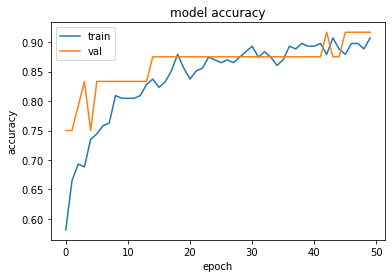

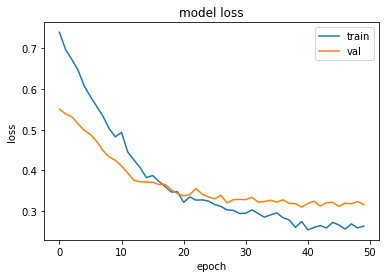

In [ ]:
plot_history(history, 'acc')
plot_history(history, 'loss')


### Conclusion

The model has an accuracy of 78% which is a good feat although the following reasons could be the cause of misclassifications:

- The proportions of observation in death events. Inbalances in the dataset affects the classifiaction

- Remove noise, inconsistent data and errors in training data - this should be done carefully with domain experts.

- Try to use some other performance metric other than 'accuracy'. It fails to be a reliable metric when data in imbalanced. That is why we have other metrics such as Precision/Recall, F1-score etc.

- Try resampling the data (undersample or oversample appropriately or stratified). Downsampling could be done with thresholding.